# Simple Milky Way Model with OMEGA+

Prepared by Benoit Côté (bcote@uvic.ca)

This notebook gives the input parameters of a simple Milky Way model with OMEGA+.  It also shows some of the observational constraints that you can use to calibrate your model.

In [1]:
# Import Python packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import pandas as pd

# make sure the parent folder (which contains JINAPyCEE and NUPYCEE) is on sys.path
repo_root = Path('/home/minjih/NuPyCEE').resolve()
package_root = repo_root.parent
if str(package_root) not in sys.path:
    sys.path.insert(0, str(package_root))

from JINAPyCEE import omega_plus

# Stellar abundances plotting code
import NuPyCEE.stellab as stellab

# Matplotlib option
%matplotlib inline

In [2]:
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"

obs_df = pd.read_csv(reichert_csv)
obs_df = obs_df.rename(columns={"ID": "star"})
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")
print(f"[Fe/H] range: {obs_df['[Fe/H]'].min():.2f} to {obs_df['[Fe/H]'].max():.2f}")
print(f"[Eu/Fe] range: {obs_df['[Eu/Fe]'].min():.2f} to {obs_df['[Eu/Fe]'].max():.2f}")

# Launch the STELLAB code
s = stellab.stellab()

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements
[Fe/H] range: -1.64 to -0.31
[Eu/Fe] range: -0.36 to 1.45


### Run OMEGA+ Model

In [3]:
# Select the yields table
# IMPORTANT NOTE: By default, only stars between 1 and 30 Msun will eject yields.
# Stars above and below this limit will eject nothing.
# You can change this assumption with the "imf_yields_range" option
imf_yields_range = [1,100]
#table = 'yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12delay.txt'
table = 'yield_tables/agb_and_massive_stars_K10_K06_0.5HNe.txt'

# Fornax-tuned parameters (years, per-year SFE)
kwargs = {
    "special_timesteps": 150,
    "t_inflow": 2.25e9, 
    "table": table,
    # Set present-day stellar mass ~4e7 Msun for Fornax
    "mgal": 4.0e7,
    # Halo / DM characteristic mass (order-of-magnitude)
    "m_DM_0": 1.0e10,
    # Star-formation efficiency: ~0.125 Gyr^-1 
    "sfe": 1.25e-10,
    "t_star": 1.0,
    # Stronger outflows expected in dwarfs; mass-loading (eta = outflow/SFR)
    "mass_loading": 4.0,
    "imf_yields_range": imf_yields_range,
    "galaxy": "fornax",
    "sn1a_table" : "yield_tables/sn1a_i99_W7.txt",
    "nb_1a_per_m": 1.5e-3, 
}

# Simple long-timescale exponential infall (single infall, tau_i = 10 Gyr)
# Format: [norm, t_start (yr), tau_infall (yr)]
exp_infall = [
    [1.0,        0.25,    14.0e9]   # long infall timescale 14 Gyr
]

In [4]:
# Run the models
op_exp = omega_plus.omega_plus(exp_infall=exp_infall, **kwargs)

OMEGA+ run in progress..
OMEGA run in progress..
   OMEGA run completed - Run time: 3.88s
   OMEGA+ run completed - Run time: 4.51s


### Extract Output Quantities

In [5]:
# OMEGA+ time array
t_op = np.array(op_exp.inner.history.age)/1.0e9

# Get the inflow rates [Msun/yr]
inflow_rate_exp = op_exp.inner.m_inflow_t/op_exp.inner.history.timesteps

# Get the total mass of gas [Msun]
m_gas_exp = np.zeros(op_exp.inner.nb_timesteps+1)
for i_t in range(op_exp.inner.nb_timesteps+1):
    m_gas_exp[i_t] = sum(op_exp.inner.ymgal[i_t])
    
# Get the total mass lost by stars [Msun]
m_star_lost = 0.0
for i_t in range(op_exp.inner.nb_timesteps):
    m_star_lost += np.sum(op_exp.inner.mdot[i_t])
    
# Get the CC and Ia SNe rates [yr^-1]
cc_sne_rate = op_exp.inner.history.sn2_numbers[1:]/op_exp.inner.history.timesteps
Ia_sne_rate = op_exp.inner.history.sn1a_numbers[1:]/op_exp.inner.history.timesteps

# Stellar mass [Msun] .. corrected for stellar mass loss
print('Current stellar mass =','%.2E' %(np.sum(op_exp.inner.history.m_locked)-m_star_lost), 'Msun')

Current stellar mass = 8.52E+07 Msun


de Boer et al. (2012) Fornax current M∗ ~ 4.3 · 10^7 M⊙

### Diagnostic Plot to Calibrate Your Milky Way Model

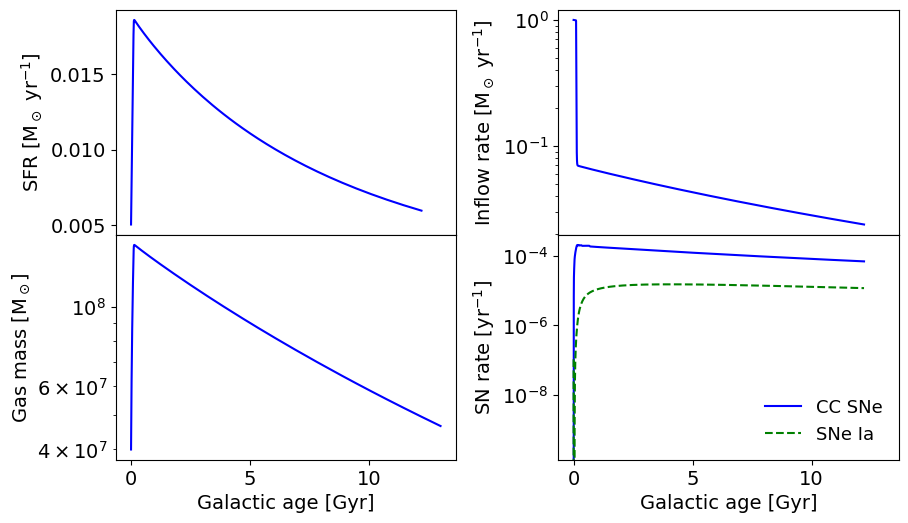

In [6]:
# Figure frame
al_f = 14 # text font
matplotlib.rcParams.update({'font.size': 14.})
f, axarr = plt.subplots(2, 2, figsize=(9,6), sharex=True, sharey=False) # [row][col]
f.subplots_adjust(hspace=0.)
f.subplots_adjust(wspace=0.3)

# Plot SFR
axarr[0][0].plot(t_op[:-1], op_exp.inner.history.sfr_abs[:-1], '-b', linewidth=1.5)

# Plot inflows
axarr[0][1].plot(t_op[:-1], inflow_rate_exp, '-b', linewidth=1.5)

# Plot gas mass
axarr[1][0].plot(t_op, m_gas_exp, '-b', linewidth=1.5)

# Plot SNe rates
axarr[1][1].plot(t_op[:-1], cc_sne_rate, '-b', linewidth=1.5, label='CC SNe')
axarr[1][1].plot(t_op[:-1], Ia_sne_rate, '--g', linewidth=1.5, label='SNe Ia')
axarr[1][1].legend(frameon=False, fontsize=13)
    
    
# Y-axis
axarr[0][0].set_ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize=al_f)
axarr[0][1].set_ylabel('Inflow rate [M$_\odot$ yr$^{-1}$]', fontsize=al_f)
axarr[0][1].set_yscale('log')
#axarr[0][1].set_ylim(3e-1,5e1)
axarr[1][0].set_ylabel('Gas mass [M$_\odot$]', fontsize=al_f)
axarr[1][0].set_yscale('log')
#axarr[1][0].set_ylim(1e9,9e10)
axarr[1][1].set_ylabel('SN rate [yr$^{-1}$]', fontsize=al_f)
axarr[1][1].set_yscale('log')
#axarr[1][1].set_ylim(1.7e-4,1e0)

# X-axis
axarr[1][0].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
axarr[1][1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)
#axarr[1][1].set_xlim(0,13)

# Adjust layout/white spaces
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.1)
plt.subplots_adjust(right=0.97)
plt.show()

The plot above is showing the predictions (lines) for the Milky Way model, while the vertical bands are observational constraints taken from <a href="http://adsabs.harvard.edu/abs/2015A%26A...580A.126K">Kubryk et al. (2015)</a>.  The gas mass represents the mass inside the galactic component, and the inflow rate represent the rate at which the circumgalactic gas is transfered into the galactic component.

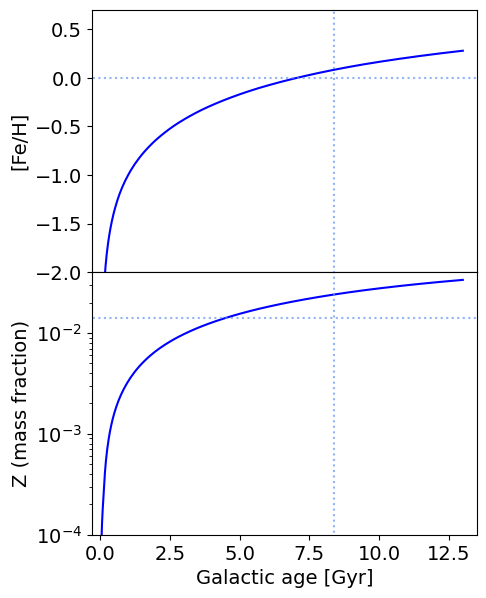

In [7]:
# Plot the age-metallicity relations
al_f = 14 # text font
matplotlib.rcParams.update({'font.size': 14.})
f, ax = plt.subplots(2,1, figsize=(5,7), sharex=True)
f.subplots_adjust(hspace=0)

# Extract predictions
o_t, o_Fe_H = op_exp.inner.plot_spectro(solar_norm='Asplund_et_al_2009', return_x_y=True)

# Plot age-[Fe/H]
# ===============
#ax[0].plot(13.-(np.array(t)), FeH, 'o', color='cornflowerblue', markersize=3, alpha=0.7)

ax[0].plot(np.array(o_t)/1e9, o_Fe_H, '-b', linewidth=1.5)

ax[0].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
ax[0].plot([-1e10,1e10], [0,0], ':', color='cornflowerblue', alpha=0.7)
ax[0].set_xlim(-0.3,13.5)
ax[0].set_ylim(-2., 0.7)

# Plot age-Z
# ==========
ax[1].plot(np.array(op_exp.inner.history.age)/1e9, op_exp.inner.history.metallicity, '-b', linewidth=1.5)

ax[1].plot([(13-4.6),(13-4.6)], [-10, 10], ':', color='cornflowerblue', alpha=0.7)
ax[1].plot([-1e10,1e10], [0.014,0.014], ':', color='cornflowerblue', alpha=0.7)
ax[1].set_yscale('log')
ax[1].set_xlim(-0.3,13.5)
ax[1].set_ylim(1e-4, 4e-2)

# Labels and visual aspect
#ax[0].legend(fontsize=16, loc=4, frameon=False)
ax[0].set_ylabel('[Fe/H]', fontsize=al_f)
ax[1].set_ylabel('Z (mass fraction)', fontsize=al_f)
ax[1].set_xlabel('Galactic age [Gyr]', fontsize=al_f)

# Adjust layout/white spaces
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.2)
plt.subplots_adjust(left=0.2)
plt.subplots_adjust(right=0.97)

The plot above shows the evolution of metallicity of the galactic gas.  The dotted lines mark the solar metallicity at the time the Sun formed, which is 4.5 Gyr before the end of the 13 Gyr-long simulation.

In [8]:
def plot_spectro_with_observations(model, yaxis = '[Eu/Fe]', xaxis = '[Fe/H]'):
    """
    Plot the stellar abundances derived from observations
    and overplot the predictions from OMEGA+.

    Parameters
    ----------
    model : omega_plus.omega_plus object
        The OMEGA+ model object containing the predictions..
    """
    # Plot stellar abundances derived from observations
    matplotlib.rcParams.update({'font.size': 16.0})
    s.plot_spectro(galaxy="fornax", xaxis=xaxis, yaxis=yaxis)
    plt.scatter(obs_df[xaxis], obs_df[yaxis], s=35, c='black', alpha=0.55, label='Reichert et al. (2020)')

    # Overplot the predictions on top of observations
    xy_0_1 = model.inner.plot_spectro(xaxis=xaxis, yaxis=yaxis, return_x_y=True)
    plt.plot(xy_0_1[0],  xy_0_1[1],  color='w', linewidth=3.0)
    plt.plot(xy_0_1[0],  xy_0_1[1],  color='m', linewidth=1.5, label='GCE prediction')

    # Update the legend and set the X and Y axis limits.
    plt.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), markerscale=0.8, fontsize=16)
    plt.ylim(-2, 1.6)
    plt.xlim(-3.2, 0.2)
    return

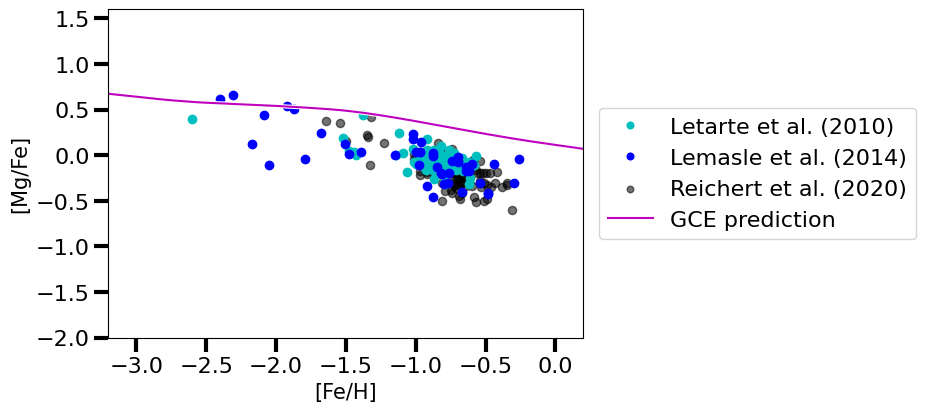

In [9]:
plot_spectro_with_observations(op_exp, yaxis = '[Mg/Fe]', xaxis = '[Fe/H]')